# Imports

In [1]:
# git-hub repo for original analysis on stories: rantsandruse/lstm_word2vec
# import associated libraries
from lib import data_split, features_word2vec
# import nltk
# nltk.download('punkt')

# For Neural Networks
import numpy as np
from lib import read_article
import pickle
import pandas as pd
import os
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Activation
from keras.layers.embeddings import Embedding
from keras.layers import Convolution1D, MaxPooling1D
from keras.models import load_model
import numpy as np

# Checking Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# Graphing and visualizing
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
from pylab import savefig


# Setting graphing preferences
sns.set(style="darkgrid", color_codes=True)

# Printing
import locale

# Show plots locally
locale.setlocale( locale.LC_ALL, '' )

%matplotlib inline

C:\Users\nites\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\nites\Anaconda3\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Using TensorFlow backend.


# Read in and Clean Data

In [2]:
songs_sample_train = pd.read_csv(r"C:\Users\nites\OneDrive\UVA\FallSemester\SYS6018\Lyric Analysis\lyric_analysis\lstm_word2vec\data\train.csv")
print(songs_sample_train.shape)
songs_sample_test = pd.read_csv(r"C:\Users\nites\OneDrive\UVA\FallSemester\SYS6018\Lyric Analysis\lyric_analysis\lstm_word2vec\data\test.csv")
print(songs_sample_test.shape)

(34930, 5)
(11644, 5)


In [3]:
songs_sample = pd.concat([songs_sample_train, songs_sample_test])
print(songs_sample.shape)

(46574, 5)


In [4]:
songs_sample.head()

,Unnamed: 0,title,artist,full_lyrics,chart
0,17599,poinciana,steve lawrence,blow tropic wind sing a song to the trees tree...,0
1,2383,live like you were dying,tim mcgraw,he said i was in my early forties with a lot o...,1
2,40051,living legends,da band,dylan yo blaze the fire and watch the enemies ...,0
3,18917,in the night side of eden,h i m,divided we stand in the light of a frozen sun ...,0
4,19625,how insensitive,rosemary clooney,how insensitive i must have seemed when she to...,0


In [5]:
songs_sample = songs_sample.drop(columns=['Unnamed: 0'])

# Generate word2vec Embeddings and Training Features

In [7]:
# Defined path of word2vec model 
model_path = "songs2vec"
model = features_word2vec.get_word2vec_model(songs_sample, "full_lyrics", num_features=300, downsampling=1e-3, model_name=model_path)

Training model...


In [8]:
print(model)

Word2Vec(vocab=18070, size=300, alpha=0.025)


In [9]:
# Create word embeddings
vector_dim = 300
embedding_weights = np.zeros((len(model.wv.vocab), vector_dim))
for i in range(len(model.wv.vocab)):
    embedding_vector = model.wv[model.wv.index2word[i]]
    if embedding_vector is not None:
        embedding_weights[i] = embedding_vector

In [11]:
# Helper Functions from the github repo
def makeIndexVec(words, model, maxLength=50, withZeros=False, padLeft=True):
    indexVec = np.zeros((maxLength,), dtype="float32")

    vocab = model.wv.vocab
    index2word_set = set(model.wv.index2word)

    if padLeft:
        # we shall always choose maxLength now.
        i = maxLength - 1
        for word in reversed(words):
            if i == 0:
                break
            if word in index2word_set:
                indexVec[i] = vocab[word].index
            i = i - 1
    else:
        i = 0
        for word in words:
            if word in index2word_set:
                indexVec[i] = vocab[word].index
            i = i + 1

    return indexVec

def get_indices_word2vec(data, column, model, maxLength=50, writeIndexFileName="./model/word2vec_indices.pickle",
                         padLeft=True, keep_freqwords=[]):
    
    reviews = read_article.data_to_reviews(data, column, keep_freqwords=keep_freqwords)
    # Initialize a counter
    counter = 0
    #
    # Preallocate a 2D numpy array, for speed
    reviewIndexVecs = np.zeros((len(reviews), maxLength), dtype="int32")
    #
    # Loop through the reviews
    for review in reviews:
        # Print a status message every 1000th review
        if counter % 1000 == 0:
            print("Review %d of %d" % (counter, len(reviews)))
        # Call the function (defined above) that makes average feature vectors
        reviewIndexVecs[counter] = makeIndexVec(review, model, maxLength, padLeft=padLeft)
        # Increment the counter
        counter = counter + 1

    # pickle.dump(reviewIndexVecs, open(writeIndexFileName, 'wb'))
    return reviewIndexVecs

In [12]:
# We also need to prepare the word2vec features, so that they are 
# each word is now mapped to an index, consistents with the training embedding 
# Currently, we are limiting each song to 500 words and padding on the left. 
features = get_indices_word2vec(songs_sample_train, "full_lyrics", model, maxLength=500,
                         writeIndexFileName="songs2vec_indices.pickle", padLeft=True )

print(embedding_weights.shape)

Review 0 of 34930
Review 1000 of 34930
Review 2000 of 34930
Review 3000 of 34930
Review 4000 of 34930
Review 5000 of 34930
Review 6000 of 34930
Review 7000 of 34930
Review 8000 of 34930
Review 9000 of 34930
Review 10000 of 34930
Review 11000 of 34930
Review 12000 of 34930
Review 13000 of 34930
Review 14000 of 34930
Review 15000 of 34930
Review 16000 of 34930
Review 17000 of 34930
Review 18000 of 34930
Review 19000 of 34930
Review 20000 of 34930
Review 21000 of 34930
Review 22000 of 34930
Review 23000 of 34930
Review 24000 of 34930
Review 25000 of 34930
Review 26000 of 34930
Review 27000 of 34930
Review 28000 of 34930
Review 29000 of 34930
Review 30000 of 34930
Review 31000 of 34930
Review 32000 of 34930
Review 33000 of 34930
Review 34000 of 34930
(18070, 300)


In [13]:
# Now we separate data for training and validation 
y = songs_sample_train["chart"]
X_train, y_train, X_test, y_test = data_split.train_test_split_shuffle(y, features, test_size = 0.1)

# Training Network

In [67]:
# CNN with LSTM
n_symbols = len(embedding_weights)
vocab_dim = len(embedding_weights[0])
# vocab_dim is basically the dimension of each embedding vector; 300 by default.
# input_dim is number of words in vocabulary +1

# Create model using Keras code
ep3_model = Sequential()  

# embedding weights is the dictionary
# change mask_zero to False
ep3_model.add(Embedding(output_dim=vocab_dim, input_dim=n_symbols, mask_zero=False, weights=[embedding_weights], dropout=0.2))  

# Add CNN layer
nb_filter=64
filter_length=5
ep3_model.add(Convolution1D(nb_filter=nb_filter,
                            filter_length=filter_length,
                            border_mode='valid',
                            activation='relu',
                            subsample_length=1))

pool_length=4
ep3_model.add(MaxPooling1D(pool_length=pool_length))

# Add LSTM layer
dense_dim=100
ep3_model.add(LSTM(dense_dim))
# return_sequences=False))
ep3_model.add(Dense(1))
ep3_model.add(Activation('sigmoid'))

# try using different optimizers and different optimizer configs
ep3_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

nb_epoch=3
batch_size=64
ep3_model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=nb_epoch, batch_size=batch_size)




C:\Users\nites\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.
  if sys.path[0] == '':
C:\Users\nites\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=64, kernel_size=5, strides=1, padding="valid")`
C:\Users\nites\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=4)`
C:\Users\nites\Anaconda3\lib\site-packages\keras\models.py:848: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 31437 samples, validate on 3493 samples
Epoch 1/3
31437/31437 [==============================] - 819s - loss: 0.2919 - acc: 0.8999 - val_loss: 0.2563 - val_acc: 0.9044
Epoch 2/3
31437/31437 [==============================] - 568s - loss: 0.2086 - acc: 0.9231 - val_loss: 0.2390 - val_acc: 0.9150
Epoch 3/3
31437/31437 [==============================] - 489s - loss: 0.1346 - acc: 0.9533 - val_loss: 0.2455 - val_acc: 0.9250


In [68]:
# Saving Generated Model
ep3_model.save('ep3_model.h5')

# Loading saved model to get predictions on test data

In [14]:
ep3_model = load_model('ep3_model.h5')

In [15]:
# Indexing words to features for the test data
features_test = get_indices_word2vec(songs_sample_test, "full_lyrics", model, maxLength=500,
                         writeIndexFileName="songs2vec_indices.pickle", padLeft=True )

Review 0 of 11644
Review 1000 of 11644
Review 2000 of 11644
Review 3000 of 11644
Review 4000 of 11644
Review 5000 of 11644
Review 6000 of 11644
Review 7000 of 11644
Review 8000 of 11644
Review 9000 of 11644
Review 10000 of 11644
Review 11000 of 11644


In [16]:
# Creating predictions on test data
test_predict = ep3_model.predict_classes(features_test)

11644/11644 [==============================] - 51s    


In [17]:
y_test = songs_sample_test["chart"]
y_test = y_test.as_matrix(columns=None)

In [18]:
# Performance on the test set

accuracy = accuracy_score(y_test, test_predict)
print("Accuracy: %.2f%%" % (accuracy * 100.0))


cnf_rf = confusion_matrix(y_test, test_predict)
print(cnf_rf)

Accuracy: 92.55%
[[10271   168]
 [  700   505]]


In [19]:
# Get the predicted probabilities 
# and the FPR and TPR

y_pred_cnn = ep3_model.predict_proba(features_test)
CNN_auc = roc_auc_score(y_test, y_pred_cnn)
print("AUC: %.2f%%" % (CNN_auc * 100.0))
CNN_fpr, CNN_tpr, CNN_thresholds = roc_curve(y_test, y_pred_cnn)

11644/11644 [==============================] - 55s    


In [ ]:
# Writing TPR and FPR probabilities for combined ROC
np.savetxt("CNN_fpr.csv", CNN_fpr, delimiter=",")
np.savetxt("CNN_tpr.csv", CNN_tpr, delimiter=",")


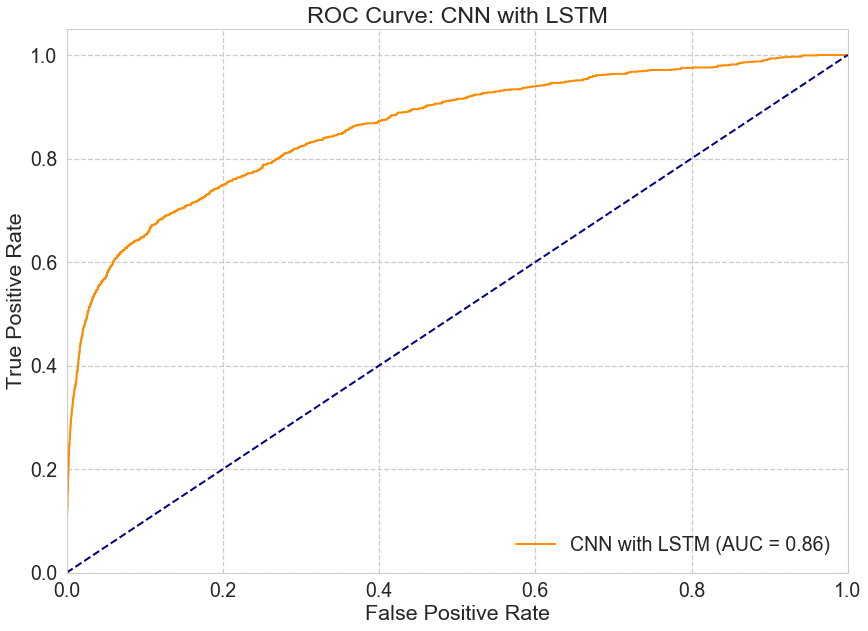

In [27]:
# ROC Plot
sns.set('talk', 'whitegrid', 'dark', font_scale=1.5, font='Arial',
        rc={"lines.linewidth": 2, 'grid.linestyle': '--'})


lw = 2
plt.figure(figsize = (14,10))
plt.plot(CNN_fpr, CNN_tpr, color='darkorange',
         lw=lw, label='CNN with LSTM (AUC = %0.2f)' % CNN_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: CNN with LSTM')
plt.legend(loc="lower right")
plt.show()
#plt.savefig('roc_auc.png')
plt.close()